In [1]:
import os
import sys
sys.path.insert(1, '../utils')
from utils import read_image, process_deconv_output
import math
import torch
import torchvision
import numpy as np
from hook import Hook
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from collections import OrderedDict
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
from hook import Hook, set_hook

In [2]:
conv_out = {}
def get_output(output):
    print(output.shape)
    conv_out[0] = output.detach()
    return output

In [21]:
def get_input(input):

    t = conv_out[0]
    print(f't shape : {t.shape}')
    max_activation = [None] * t.shape[1]

    # For each of the feature map find the maximum activation
    for kernal in range(t.shape[1]):
        max_activation[kernal] = (kernal, torch.max(t[0, kernal, :, :]).item(),
            torch.argmax(t[0, kernal, :, :]).item())

    # Sort features according to their maximum activation value    
    max_activation.sort(key=lambda x: x[1], reverse=True)

    # Construct "num_kernel" number of input tensor for deconv model
    dconv_input = torch.zeros_like(t)
    index = np.unravel_index(max_activation[0][2], (t.shape[2], t.shape[3]))
    #dconv_input[0, max_activation[0][0], index[0], index[1]] = t[0, max_activation[0][0], index[0], index[1]]
    dconv_input[0, max_activation[0][0], index[0], index[1]] = 1.0
    #return (dconv_input,)
    return (dconv_input, input[1], input[2])

In [22]:
imagenet = models.vgg16(pretrained=True)
imagenet = imagenet.eval()

In [23]:
image_path = '../test/birds.jpg'
image = read_image(image_path)
image.requires_grad=True

forward hook set on layer features_28
backward hook set on layer features_28
features_28 layer hooked
torch.Size([1, 512, 14, 14])
forward hook executed on layer features_28
tensor(-2.5003, grad_fn=<SumBackward0>)
t shape : torch.Size([1, 512, 14, 14])
backward hook executed on layer features_28
[<hook.Hook object at 0x7f21936963d0>, <hook.Hook object at 0x7f21936968e0>]
forward hook on layer features_28 removed
backward hook on layer features_28 removed


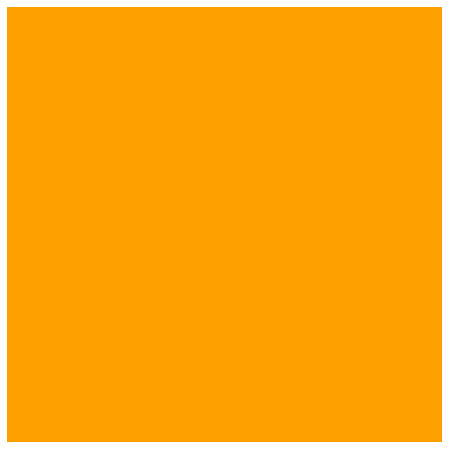

In [24]:
hooks = set_hook(imagenet, backward_input_fn = get_input, forward_output_fn = get_output)
out = imagenet(image)
loss = torch.sum(out)
print(loss)
loss.backward()
print(hooks)
for hook in hooks:
    hook.remove()
out = process_deconv_output(image.grad.detach())
out = torchvision.utils.make_grid(out.unsqueeze(0), normalize=True)
plt.gcf().set_size_inches(8, 8)
plt.axis('off')
plt.imshow(out.permute(1, 2, 0))
plt.show()

In [26]:
t = torch.randn(2, 2)

In [27]:
t

tensor([[ 0.6118, -0.9648],
        [-0.8596, -1.4404]])

In [29]:
t = nn.Conv2d(2, 2, 3)

In [31]:
t.register_backward_hook??